In [96]:
#pip install transformers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer, AutoModel
import torchxrayvision as xrv
import time
from collections import Counter

In [98]:
#!git clone https://github.com/ieee8023/covid-chestxray-dataset

In [2]:
data = xrv.datasets.COVID19_Dataset(imgpath="covid-chestxray-dataset/images/",csvpath="covid-chestxray-dataset/metadata.csv")

In [3]:
data

{'Aspergillosis': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Aspiration': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Bacterial': {np.float32(0.0): 487, np.float32(1.0): 48},
 'COVID-19': {np.float32(0.0): 193, np.float32(1.0): 342},
 'Chlamydophila': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Fungal': {np.float32(0.0): 512, np.float32(1.0): 23},
 'H1N1': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Herpes ': {np.float32(0.0): 532, np.float32(1.0): 3},
 'Influenza': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Klebsiella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Legionella': {np.float32(0.0): 526, np.float32(1.0): 9},
 'Lipoid': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MERS-CoV': {np.float32(0.0): 527, np.float32(1.0): 8},
 'MRSA': {np.float32(0.0): 534, np.float32(1.0): 1},
 'Mycoplasma': {np.float32(0.0): 530, np.float32(1.0): 5},
 'No Finding': {np.float32(0.0): 520, np.float32(1.0): 15},
 'Nocardia': {np.float32(0.0): 531, np.float32(1.0): 4},
 'Pneumocystis': 

COVID19_Dataset num_samples=535 views=['PA', 'AP'] data_aug=None

In [4]:
df = data.csv

In [5]:
labels = []
for i in range(len(data)):
    pd.Series(dict(zip(data.pathologies,data[i]["lab"])))
    labels.append(pd.Series(dict(zip(data.pathologies,data[i]["lab"]))))

labels = pd.DataFrame(labels)

In [6]:
labels = labels['COVID-19']

In [7]:
df['clinical_notes']

0      On January 22, 2020, a 65-year-old man with a ...
1      On January 22, 2020, a 65-year-old man with a ...
2      On January 22, 2020, a 65-year-old man with a ...
3      On January 22, 2020, a 65-year-old man with a ...
4       diffuse infiltrates in the bilateral lower lungs
                             ...                        
530    Decreased SpO2, elevated CRP and WBC, diffuse ...
531    Asthmatic. Shortness of breath and wheeze. Rou...
532    Asthmatic. Shortness of breath and wheeze. The...
533    fire-eater accidentally ingested a paraffin mi...
534    The patient, a heavy smoker, was referred to t...
Name: clinical_notes, Length: 535, dtype: object

In [8]:
print(labels)

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
530    0.0
531    0.0
532    0.0
533    0.0
534    0.0
Name: COVID-19, Length: 535, dtype: float32


In [ ]:
#eu reutilizei esse código pra todos os quatro modelos de texto que experimentei, 
#só trocando o path do tokenizer e o nome do modelo na classe Classifier
#por isso, aparece só um aqui, o último que testei. 

In [103]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
pbmbert_model = AutoModel.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')

In [104]:
X_temp, X_test, y_temp, y_test = train_test_split(df, labels, 
                                                  test_size=0.15, 
                                                  stratify=labels, 
                                                  random_state=12)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, 
                                                  test_size=0.12, 
                                                  stratify=y_temp, 
                                                  random_state=33)

In [105]:
#garantindo os tipos exigidos pelo modelo (nossos labels estavam como floats e ele não aceita)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

In [106]:
#criando dataset com as notas médicas
class ClinicalNotesDataset(Dataset):
    def __init__(self, df, labels, tokenizer, max_len):
        self.texts = df['clinical_notes'].values
        self.labels = labels.values 
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length', #batchs de mesmo tamanho
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [107]:
#com a classe criada, instanciamos e criamos os datasets
train_dataset = ClinicalNotesDataset(X_train, y_train, tokenizer, max_len=128)
val_dataset = ClinicalNotesDataset(X_val, y_val, tokenizer, max_len=128)
test_dataset = ClinicalNotesDataset(X_test, y_test, tokenizer, max_len=128)

In [108]:
#e os data loaders
train_loader = DataLoader(train_dataset, batch_size=18, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [109]:
#modificando a classe do classificador
class PBMClassifier(nn.Module):
    def __init__(self, pbmbert_model):
        super(PBMCBERTClassifier, self).__init__()
        self.pbmbert = pbmbert_model
        for param in self.pbmbert.parameters():
            param.requires_grad = False #congelamos tudo para fazer só feature extraction primeiro
#caso nenhum modelo tivesse resultado bom dessa forma, pensaríamos em descongelar alguns parametros progressivamente
#mas essa era nossa última opção, porque o dataset era pequeno e duvidavamos muito que o modelo convergisse                        

        self.classifier = nn.Sequential(
                            nn.Linear(768, 256),
                            nn.ReLU(),
                            nn.Dropout(0.25),
                            nn.Linear(256, 2)
                        )  #colocamos uma camada bem simples aqui porque queríamos avaliar ao máximo o modelo, 
#e não misturar isso "capacidade" da camada fully connected

    def forward(self, input_ids, attention_mask):
        outputs = self.pbmbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  #[CLS]
        logits = self.classifier(pooled_output)
        return logits

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [110]:
#essa função é a mesma que usamos com imagens, apenas adaptada
def train_and_validate_text(model, loss_criterion, optimizer, epochs, dataset="pbmbert_text",
                            train_data_loader=train_loader, val_data_loader=val_loader, train_data_size=len(train_dataset),
                            val_data_size=len(val_dataset), device=device):

    start = time.time()
    history = []
    best_loss = 1e8
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()

        model.train()

        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        all_val_labels = []
        all_val_predictions = []

        # Loop de treino
        for i, batch in enumerate(train_data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            loss = loss_criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * input_ids.size(0)

            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * input_ids.size(0)

        #loop de validação
        with torch.no_grad():
            model.eval()

            for j, batch in enumerate(val_data_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)

                loss = loss_criterion(outputs, labels)
                valid_loss += loss.item() * input_ids.size(0)

                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * input_ids.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_predictions.extend(predictions.cpu().numpy())

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / val_data_size
        avg_valid_acc = valid_acc / val_data_size

        recall_majority = recall_score(all_val_labels, all_val_predictions, pos_label=1)
        sensitivity_minority = recall_score(all_val_labels, all_val_predictions, pos_label=0)
        accuracy = accuracy_score(all_val_labels, all_val_predictions)

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc, recall_majority])

        epoch_end = time.time()
        print("\nEpoch {}/{}: {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t      Validation: Loss - {:.4f}, Accuracy - {:.4f}% \nRecall (COVID) - {:.4f}, Sensitivity (SEM COVID) - {:.4f}, Time: {:.4f}s".format(
            epoch + 1, epochs, epoch, avg_train_loss, avg_train_acc * 100, avg_valid_loss, avg_valid_acc * 100, recall_majority, sensitivity_minority, epoch_end - epoch_start))

    return model, history, best_epoch

In [112]:
model = CBERTClassifier(cbert_model).to(device)

In [119]:
#colocamos pesos diferentes pras classes na loss porque o dataset era desbalanceado 
#e tivemos muito o problema de a rede só chutar a classe majoritária e não aprender nada
boost = 2.9
counter = Counter(y_train)
weight = (counter[0] / counter[1]) * boost

In [120]:
print(weight)

1.6376470588235292


In [124]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([weight, 1.0]).to(device))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=8e-5)

In [125]:
trained_model, history, best_epoch = train_and_validate_text(
    model=model,
    loss_criterion=criterion,
    optimizer=optimizer,
    epochs=10)


Epoch 1/10: 000, Training: Loss - 0.4877, Accuracy - 79.1980%, 
	      Validation: Loss - 0.4575, Accuracy - 76.3636% 
Recall (COVID) - 0.7714, Sensitivity (SEM COVID) - 0.7500, Time: 33.2471s

Epoch 2/10: 001, Training: Loss - 0.4755, Accuracy - 78.1955%, 
	      Validation: Loss - 0.4552, Accuracy - 76.3636% 
Recall (COVID) - 0.7714, Sensitivity (SEM COVID) - 0.7500, Time: 33.0949s

Epoch 3/10: 002, Training: Loss - 0.4885, Accuracy - 77.9449%, 
	      Validation: Loss - 0.4516, Accuracy - 78.1818% 
Recall (COVID) - 0.8000, Sensitivity (SEM COVID) - 0.7500, Time: 32.9064s

Epoch 4/10: 003, Training: Loss - 0.4851, Accuracy - 78.4461%, 
	      Validation: Loss - 0.4583, Accuracy - 74.5455% 
Recall (COVID) - 0.7143, Sensitivity (SEM COVID) - 0.8000, Time: 32.8015s

Epoch 5/10: 004, Training: Loss - 0.4712, Accuracy - 80.2005%, 
	      Validation: Loss - 0.4496, Accuracy - 76.3636% 
Recall (COVID) - 0.7714, Sensitivity (SEM COVID) - 0.7500, Time: 33.5877s

Epoch 6/10: 005, Training: Lo

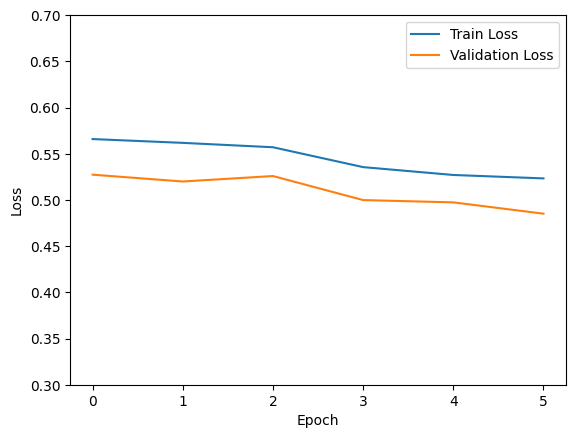

In [120]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0.4, 0.6)
plt.show()

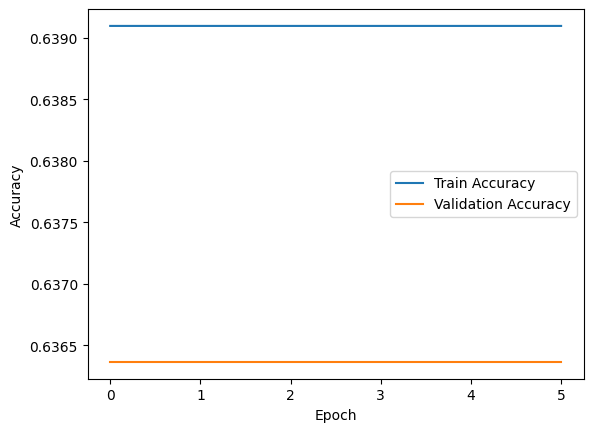

In [121]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [123]:
torch.save(model.state_dict(), 'pbmbert_model_toupdate.pth')